In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, exposure, filters
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold ,KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import warnings 
warnings.filterwarnings("ignore")


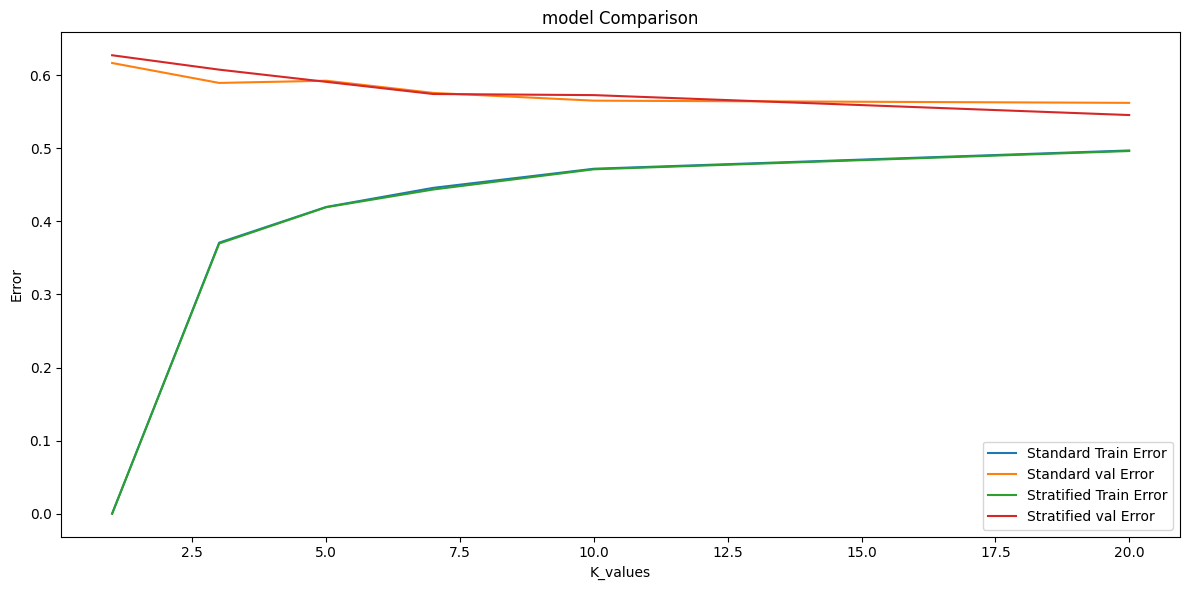

In [16]:
crop_folder=r'Cropped'
classes=os.listdir(crop_folder)
def edge_histogram(images):
    imgs=[]
    classs=[]
    for idx,pt in enumerate(images):
        path = os.path.join(crop_folder,pt)
        for img in os.listdir(path):
            src_pt = os.path.join(path, img)
            image = io.imread(src_pt)
            gray_img = color.rgb2gray(image)
            dx, dy = filters.sobel_h(gray_img), filters.sobel_v(gray_img)
            angle_sobel = np.mod(np.arctan2(dy, dx), np.pi)
            hist, bins = exposure.histogram(angle_sobel, nbins=36)
            imgs.append(hist)
            classs.append(idx)
            
    imgs=np.array(imgs)
    classs=np.array(classs)
    return imgs,classs

imgs,classs=edge_histogram(classes)

X_train, X_test, y_train, y_test = train_test_split(imgs,classs, test_size=0.2,stratify=classs, random_state=42)
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

K = [1,3,5,7,10,20]

sf=KFold(n_splits=5)
skf=StratifiedKFold(n_splits=5)
folds=[sf,skf]
for fold in folds:
    if fold==sf:
        st_errors,sv_errors =[],[]
        for k in K:
            KNN = KNeighborsClassifier(n_neighbors=k)
            st,sv = [],[]
            for train_idx, test_idx in fold.split(X_train, y_train):
                xtrain, xval = X_train[train_idx], X_train[test_idx]
                ytrain, yval = y_train[train_idx], y_train[test_idx]
                KNN.fit(xtrain, ytrain)
                t_pred = KNN.predict(xtrain)
                v_pred = KNN.predict(xval)
                t_acc = accuracy_score(ytrain, t_pred)
                v_acc = accuracy_score(yval, v_pred)
                st.append(1-t_acc)
                sv.append(1-v_acc)
            st_errors.append(np.mean(st))
            sv_errors.append(np.mean(sv))
    else:
        str_errors,svr_errors =[],[]
        for k in K:
            KNN = KNeighborsClassifier(n_neighbors=k)
            str,svr = [],[]
            for train_idx, test_idx in fold.split(X_train, y_train):
                xtrain, xval = X_train[train_idx], X_train[test_idx]
                ytrain, yval = y_train[train_idx], y_train[test_idx]
                KNN.fit(xtrain, ytrain)
                tr_pred = KNN.predict(xtrain)
                vr_pred = KNN.predict(xval)
                tr_acc = accuracy_score(ytrain, tr_pred)
                vr_acc = accuracy_score(yval, vr_pred)
                str.append(1-tr_acc)
                svr.append(1-vr_acc)
            str_errors.append(np.mean(str))
            svr_errors.append(np.mean(svr))

            
            
            
plt.figure(figsize=(12, 6))
plt.plot(K, st_errors, label='Standard Train Error')
plt.plot(K, sv_errors, label='Standard val Error')
plt.plot(K, str_errors, label='Stratified Train Error')
plt.plot(K, svr_errors, label='Stratified val Error')
plt.xlabel('K_values')
plt.ylabel('Error')
plt.title('model Comparison')
plt.legend()
plt.tight_layout()
plt.show()



the lowest mean error : Standard Training error      at k=1 
                        stratified Training error    at k=1 
                        standard validation error    at k=10
                        stratified validation error  at k=20

the model complexity : Less         at k = 1
                       Intermidiate at k = 3,5,7,10
                       high         at k = 20
 

model  overfits at k = 1   training error is less validation is more and is over fitted to just 1 neighbor.
      and  underfits at k =20   more neighbours making model diverse and classifies incorrectly

In [17]:
model = KNeighborsClassifier(n_neighbors = 20)
model.fit(X_train, y_train)
pred = model.predict(X_test)
acc=accuracy_score(y_test,pred)


In [18]:
err=1-acc
print("Test Error")
print(err)

Test Error
0.6


MLPClassifier(hidden_layer_sizes=(10, 10, 10))
Mean validation accuracy
0.4545454545454545
Test accuracy
0.3878787878787879
F1-measure
0.3813109972128987


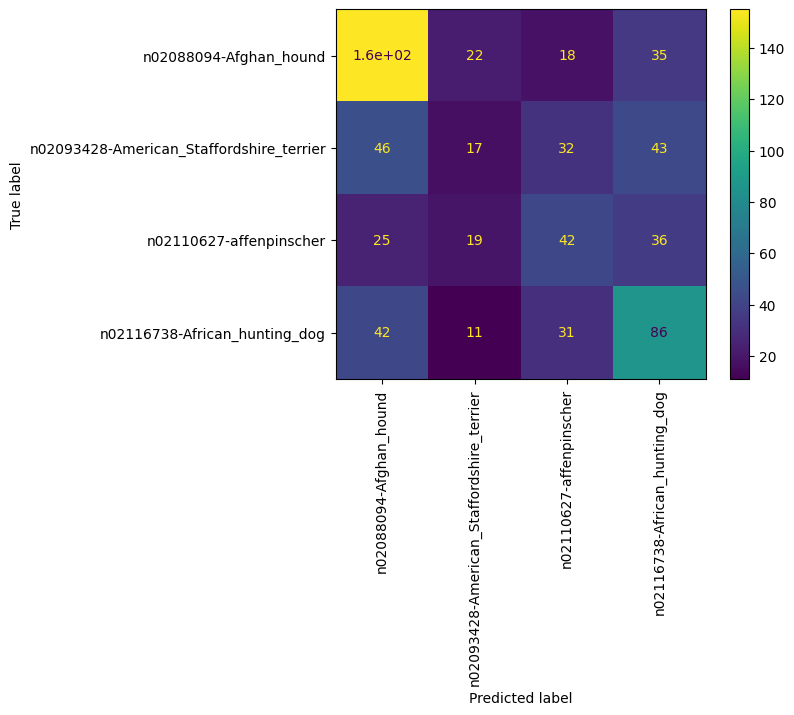

AdaBoostClassifier()
Mean validation accuracy
0.40606060606060607
Test accuracy
0.28484848484848485
F1-measure
0.27562874499949336


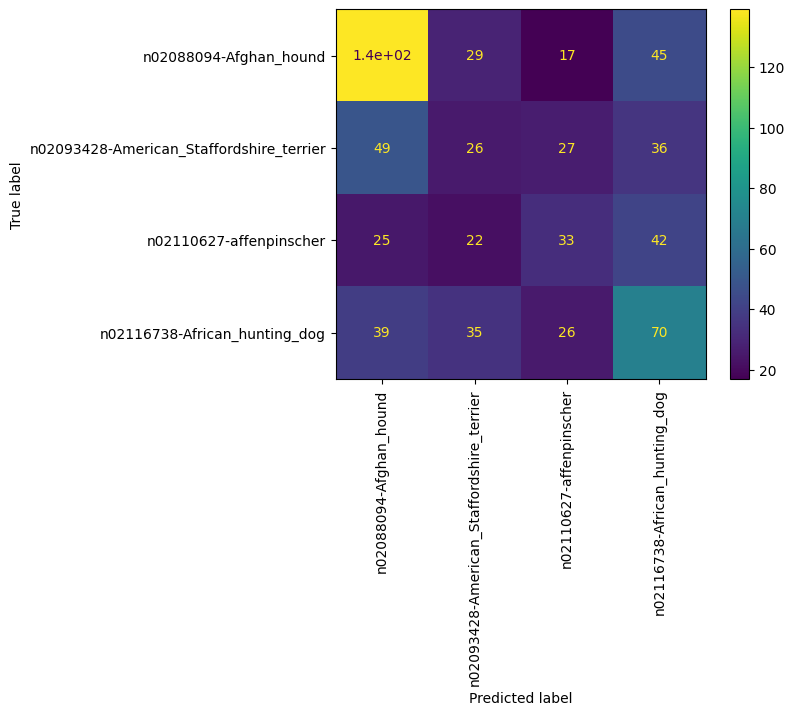

GaussianNB()
Mean validation accuracy
0.39090909090909093
Test accuracy
0.3393939393939394
F1-measure
0.334803767541666


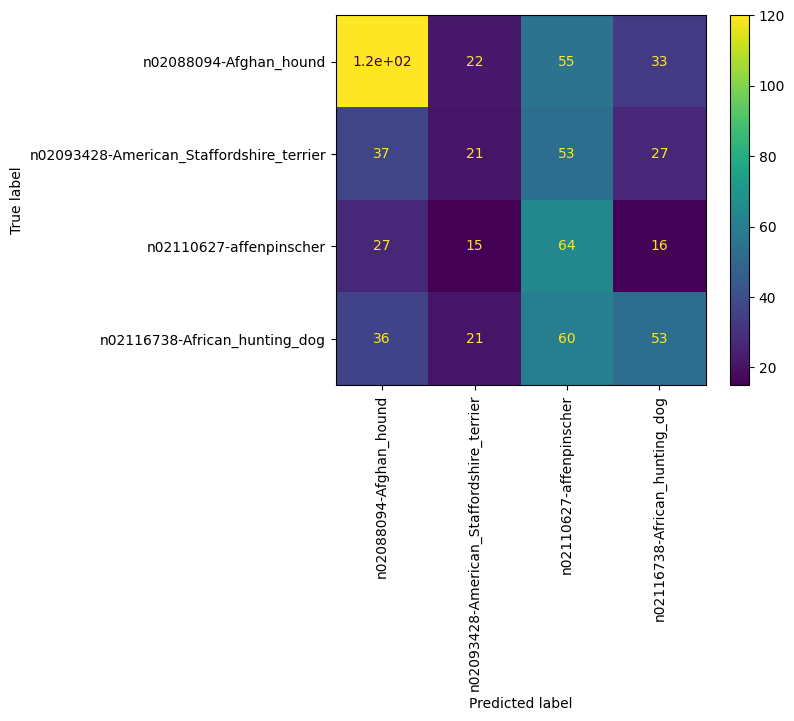

In [36]:
def performance(clf):
    pred=clf.predict(X_test)
    test_acc= accuracy_score(y_test,pred)
    print("Test accuracy")
    print(test_acc)
    f1_test = f1_score(y_test, pred, average='weighted')
    print("F1-measure")
    print(f1_test)
          

def classifers_compare(classifiers):
    for classifier in classifiers:
        Actual,predict,validation,confu_m=[],[],[],[]
        for train_idx, test_idx in skf.split(X_train, y_train):
            xtrain, xval = X_train[train_idx], X_train[test_idx]
            ytrain, yval = y_train[train_idx], y_train[test_idx]
            classifier.fit(xtrain, ytrain)
            pred= classifier.predict(xval)
            Actual.extend(yval)
            predict.extend(pred)
            val = accuracy_score(yval, pred)
            validation.append(val)
        k=np.mean(validation)
        print(classifier)
        print("Mean validation accuracy")
        print(k)
        performance(classifier)
        confu_m.append(confusion_matrix(Actual, predict))
        cm_display = ConfusionMatrixDisplay(confusion_matrix = sum(confu_m)/len(confu_m), display_labels = classes)
        cm_display.plot(xticks_rotation=90)
        plt.show()

classify=[MLPClassifier(hidden_layer_sizes=(10,10,10)),AdaBoostClassifier(),GaussianNB()]
classifers_compare(classify)

### Based on confusion matrix , f1 score , test accuracy, mean validation accuracy MLP classifier performs best